In [1]:
MAIN_PATH = "/home/carlos/MasterDS/tfm"
JSON_DATA_PATH = '{}/data/json/'.format(MAIN_PATH)
CSV_DATA_PATH = '{}/data/csv/'.format(MAIN_PATH)

In [2]:
import sys
sys.path.insert(0, MAIN_PATH)

In [86]:
%load_ext autoreload
%autoreload 2
from scripts.models.ltr_beinf.train import LTRBEINFTrain
from scripts.models.ltr_beinf.metrics import LTRBEINFMetrics
from scripts.models.ltr_beinf.train_imbalanced_rf import BEINFImbalancedTrainRandomForest
from scripts.models.ltr_beinf.metrics_imbalanced import BEINFImbMetrics

import scripts.utils.visualizations as vis_utils
import scripts.utils.ml_utils as ml_utils
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Métricas modelo BEINF

Se pretende extraer métricas para comparar el rendimiento de este modelo, que ha sido entrenado en R.

## Parámetros entrenamiento

In [105]:
ltr_params = {
    'key_events': ['goal', 'red_card', 'penalty'],
    'lags': [1, 3, 5],
    'target_metric': 'rouge',
    'drop_teams': True,
    'lemma': True,
    'metric_params': {'rouge_mode': 'rouge-1', 'rouge_metric': 'r'},
    'count_vec_kwargs': {'ngram_range': (1, 2), 'strip_accents': 'unicode'}
}
cat_features_dict = {'is_key_event': [0, 1]}
num_features = ['tfidf_sum']
# Debería estar vacío, lo guardamos por el hash
model_params = {
    'mu': 0.12,
    'sigma': 0.13,
    'nu': 0.461,
    'tau': 0.009
}

In [6]:
ltr_train = LTRBEINFTrain(cat_features_dict=cat_features_dict, num_features=num_features,
                          model_params=model_params, ltr_params=ltr_params)

Setting target metric to rouge


## Carga de resultados

En R se ha generado lo siguiente:
- Predicciones de la media para cada vector de características
- Predicciones de la probabilidad de 0 (p0) para cada registro
- Predicciones de la probabilidad de 1 (p1) para cada registro

In [33]:
ltr_metrics = LTRBEINFMetrics(ltr_train)

In [36]:
predictions_df = ltr_metrics.get_predictions('train')

In [37]:
predictions_df

,mu,p0,p1
0,0.171706,0.219187,0.006311
1,0.142973,0.543726,0.002806
2,0.211419,0.048206,0.010624
3,0.150408,0.445206,0.003677
4,0.142760,0.546569,0.002782
...,...,...,...
296655,0.163282,0.295617,0.005277
296656,0.172564,0.212405,0.006414
296657,0.175083,0.193529,0.006714
296658,0.143139,0.541464,0.002825


## Evaluación modelos clasificación

Se realiza lo siguiente:

- Se toma el vector p0 como las predicciones de un modelo de clasificación
para distinguir entre 0s y no 0s.
- Lo mismo con el vector p1
- Se evaluan estos modelos de clasificación
- Fijando un umbral para cada tipo de probabilidad, se filtran los
registros que los modelos identifican como 0s y 1s
- Con los registros restantes, se usa el vector de medias del modelo BEINF
como la estimación puntual del score que buscamos. Evaluaremos este score
con las métricas utilizadas en los demás ejemplos.

### Modelo 0

#### Train

In [8]:
data_type = 'train'
int_class = 0
metric = 'f1'

In [9]:
df_label = ltr_metrics._label_data(data_type, int_class)

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 203604 68.63210409222678
Number of 1s: 93056 31.367895907773207


Parece que los 1s tienen probabilidades mayores...

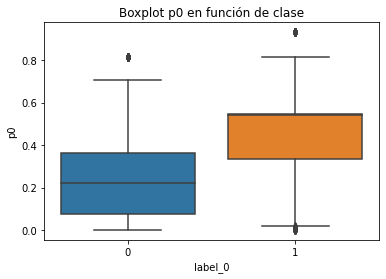

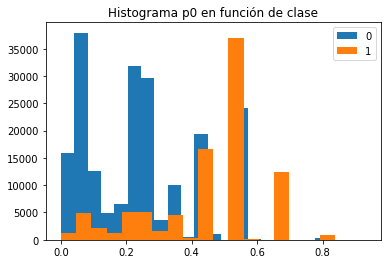

In [266]:
vis_utils.classification_plots(df_label, int_class)

In [10]:
df_model_score = ltr_metrics.apply_class_model(data_type, int_class, metric)

Filtering non 0s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 203604 68.63210409222678
Number of 1s: 93056 31.367895907773207
Computing metrics with different ths
Using 0.39473684210526316 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_th_metrics_0.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_class_metrics_0.pickle
Converting df scores


In [11]:
metrics_th, metrics_class = ltr_metrics.read_class_model_metrics(int_class=int_class, data_type=data_type)

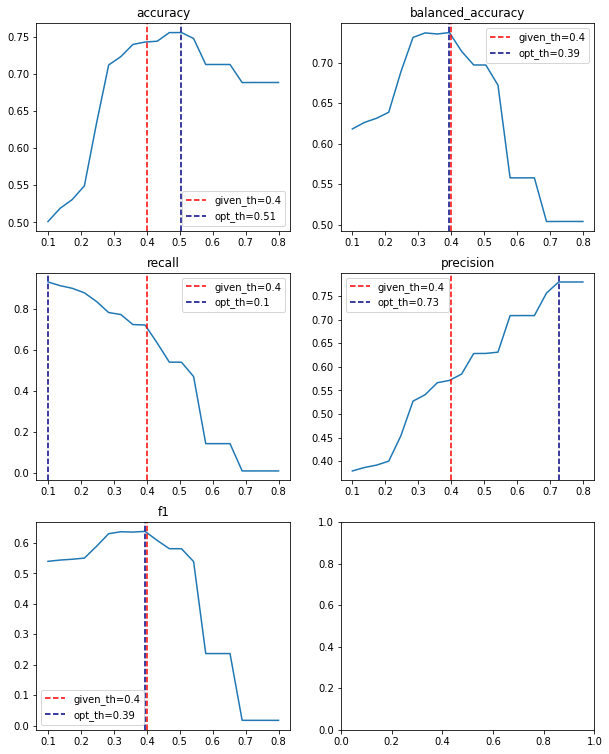

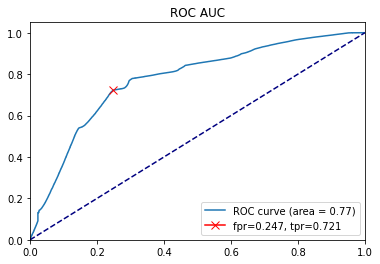

In [15]:
vis_utils.classification_metrics_th(metrics_th, height=13, th=0.4)

In [283]:
metrics_class

{'accuracy': 0.7428436594080766,
 'precision': 0.5713131347498427,
 'recall': 0.7217911795048143,
 'f1': 0.6377966214355575,
 'conf_matrix': array([[153205,  50399],
        [ 25889,  67167]])}

#### Validation

In [16]:
data_type = 'validation'
int_class = 0
metric = 'f1'

In [275]:
df_label = ltr_metrics._label_data(data_type, int_class)

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 58321 68.80722038697499
Number of 1s: 26439 31.192779613025014


Parece que los 1s tienen probabilidades mayores...

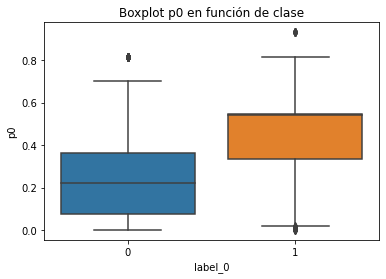

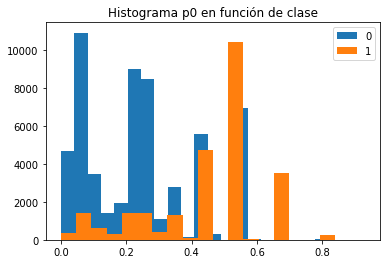

In [276]:
vis_utils.classification_plots(df_label, int_class)

In [23]:
df_model_score = ltr_metrics.apply_class_model(data_type, int_class, metric)

Filtering non 0s from validation dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 58321 68.80722038697499
Number of 1s: 26439 31.192779613025014
Computing metrics with different ths
Using 0.32105263157894737 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_th_metrics_0.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_class_metrics_0.pickle
Converting df scores


In [31]:
df_model_score

0         NaN
1         NaN
2         1.0
3         NaN
4         NaN
         ... 
296655    NaN
296656    NaN
296657    NaN
296658    NaN
296659    NaN
Name: mod_class_1, Length: 296660, dtype: float64

In [24]:
metrics_th, metrics_class = ltr_metrics.read_class_model_metrics(int_class=int_class, data_type=data_type)

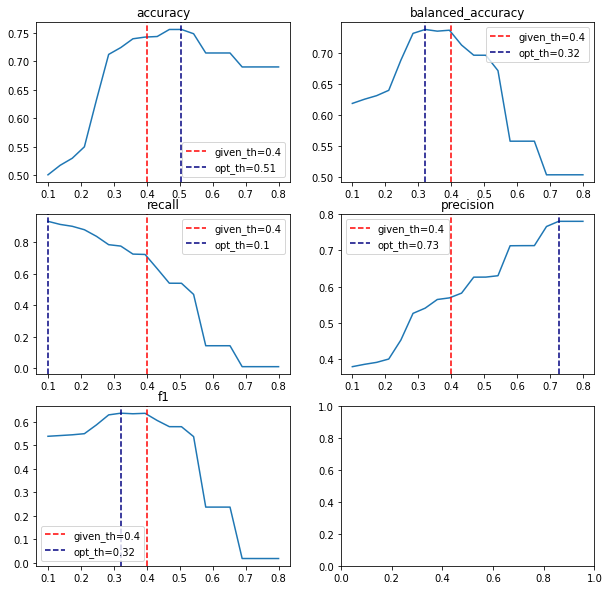

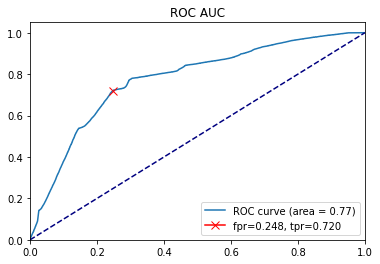

In [19]:
vis_utils.classification_metrics_th(metrics_th, th=0.4)

In [25]:
metrics_class

{'accuracy': 0.7240089664936291,
 'balanced_accuracy': 0.7377787139912382,
 'precision': 0.5401825761173553,
 'recall': 0.7743863232346155,
 'f1': 0.6364215663418349,
 'roc_auc': 0.7739987432748412,
 'conf_matrix': array([[40893, 17428],
        [ 5965, 20474]])}

### Modelo 1

#### Train

In [101]:
data_type = 'train'
int_class = 1
metric_dict = {'metric': 'f1'}

In [27]:
df_label = ltr_metrics._label_data(data_type, int_class)

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 294895 99.40504280995079
Number of 1s: 1765 0.5949571900492145


Las probabilidades aquí son mucho más pequeñas, ya que el número de 1s
es sensiblemente menor. Parece que los 1s tienen un score ligeramente superior...

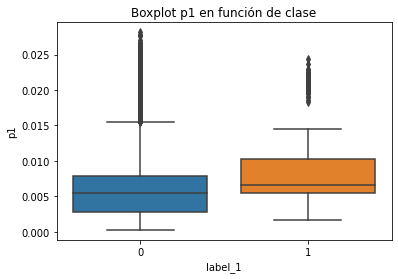

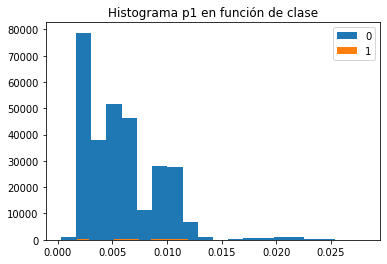

In [287]:
vis_utils.classification_plots(df_label, int_class)

Tenemos un desbalanceo muy grande. Probablemente haya que entrenar un modelo
específico para este caso y no nos valga lo que sale de R directamente. 

In [102]:
df_model_score = ltr_metrics.apply_class_model(data_type, int_class, metric_dict)

Filtering non 1s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 294895 99.40504280995079
Number of 1s: 1765 0.5949571900492145
Computing metrics with different ths
Using 0.01 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_th_metrics_1.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_class_metrics_1.pickle
Converting df scores


In [103]:
metrics_th, metrics_class = ltr_metrics.read_class_model_metrics(int_class=int_class, data_type=data_type)

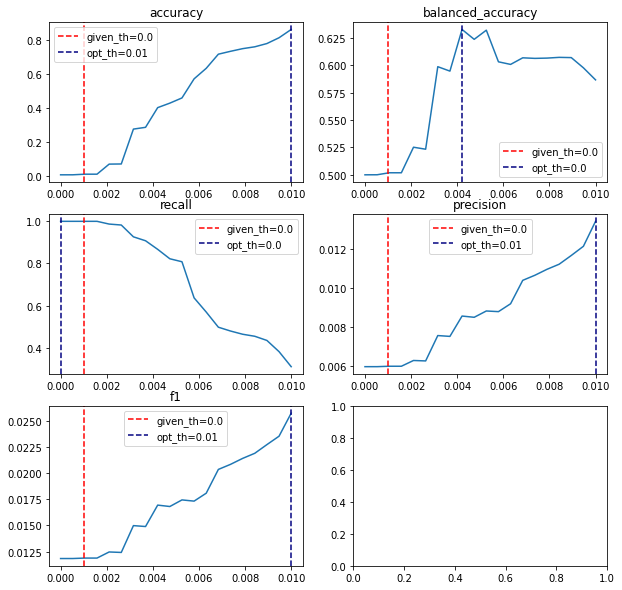

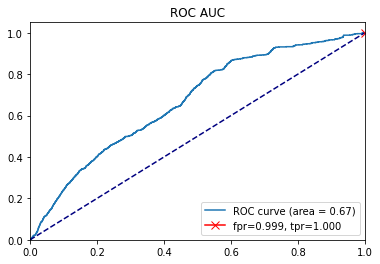

In [30]:
vis_utils.classification_metrics_th(metrics_th, th=0.001)

In [104]:
metrics_class

{'accuracy': 0.8604698981999596,
 'balanced_accuracy': 0.5865584509433353,
 'precision': 0.013408644400785855,
 'recall': 0.3093484419263456,
 'f1': 0.025703189360950923,
 'roc_auc': 0.6672162382471851,
 'conf_matrix': array([[254721,  40174],
        [  1219,    546]])}

#### Validation

In [292]:
data_type = 'validation'
int_class = 1
metric = 'f1'

In [293]:
df_label = ltr_metrics._label_data(data_type, int_class)

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 84286 99.4407739499764
Number of 1s: 474 0.559226050023596


Parece que los 1s tienen probabilidades mayores...

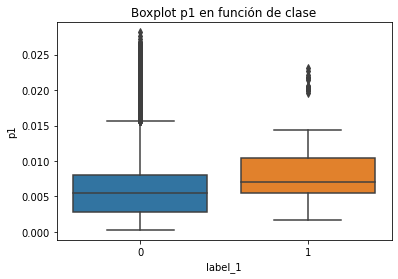

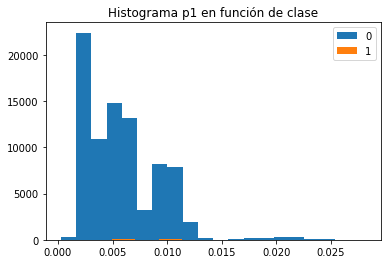

In [294]:
vis_utils.classification_plots(df_label, int_class)

In [295]:
df_model_score = ltr_metrics.apply_class_model(data_type, int_class, metric)

Filtering non 1s from validation dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 84286 99.4407739499764
Number of 1s: 474 0.559226050023596
Computing metrics with different ths
Using 0.01 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_th_metrics_1.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_class_metrics_1.pickle
Converting df scores


In [296]:
metrics_th, metrics_class = ltr_metrics.read_class_model_metrics(int_class=int_class, data_type=data_type)

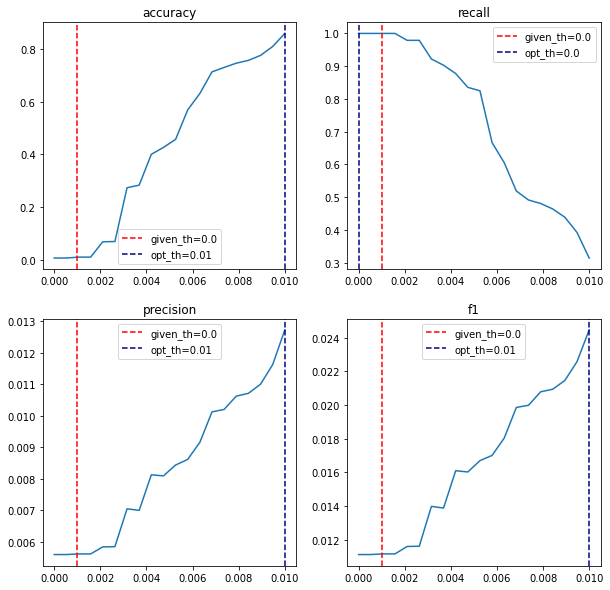

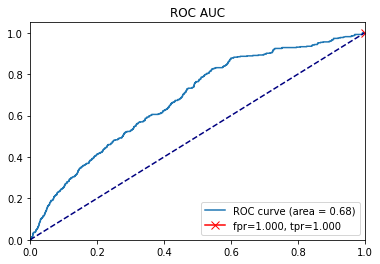

In [297]:
vis_utils.classification_metrics_th(metrics_th, th=0.001)

In [298]:
metrics_class

{'accuracy': 0.8598041529023124,
 'precision': 0.012727428034509268,
 'recall': 0.3143459915611814,
 'f1': 0.0244643296937854,
 'conf_matrix': array([[72728, 11558],
        [  325,   149]])}

### Combinación de modelos

Se aplican ambos modelos sobre el score. Se debe tener cuidado si un registro tiene modificaciones por ambos modelos.

In [93]:
data_type = 'train'
metric_dict = {
    0: {'metric': 'f1',
        'th': 0.4},
    1: {'metric': 'f1'}
}
"""
metric_dict = {
    0: {'metric': 'f1',
        'th': 0.4},
    1: {'metric': 'f1'}
}
"""

"\nmetric_dict = {\n    0: {'metric': 'f1',\n        'th': 0.4},\n    1: {'metric': 'f1'}\n}\n"

In [94]:
ltr_metrics = LTRBEINFMetrics(ltr_train, class_metric_dict=metric_dict)

In [95]:
df_models = ltr_metrics.combine_models(data_type=data_type)

Filtering non 0s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 203604 68.63210409222678
Number of 1s: 93056 31.367895907773207
Computing metrics with different ths
Using 0.4 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_th_metrics_0.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_class_metrics_0.pickle
Converting df scores
Filtering non 1s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 294895 99.40504280995079
Number of 1s: 1765 0.5949571900492145
Computing metrics with different ths
Using 0.01 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_th_metrics_1.pick

In [81]:
df_models

,pred,score
0,0.171706,0.166667
1,0.000000,0.000000
2,1.000000,0.200000
3,0.000000,0.333333
4,0.000000,0.000000
...,...,...
296655,0.163282,0.500000
296656,0.172564,0.083333
296657,0.175083,0.100000
296658,0.000000,0.000000


No hay registros donde los modelos se confunden (menos al)

In [65]:
df_models[~df_models['model_0'].isna() & ~df_models['model_1'].isna()]

,model_0,model_1,pred,score


Métricas

In [84]:
metrics = ltr_metrics.metrics('train')

Filtering non 0s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 203604 68.63210409222678
Number of 1s: 93056 31.367895907773207
Computing metrics with different ths
Using 0.39473684210526316 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_th_metrics_0.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_class_metrics_0.pickle
Converting df scores
Filtering non 1s from train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Number of 0s: 294895 99.40504280995079
Number of 1s: 1765 0.5949571900492145
Computing metrics with different ths
Using 0.01 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/train_t

In [85]:
metrics

{'mse': 0.10141376673232362,
 'mae': 0.17677199179693778,
 'r2': -4.4439504539042645,
 'y_true': array([0.16666667, 0.        , 0.2       , ..., 0.1       , 0.        ,
        0.        ]),
 'y_pred': array([0.17170579, 0.        , 1.        , ..., 0.17508259, 0.        ,
        0.        ]),
 'error': array([-0.00503913,  0.        , -0.8       , ..., -0.07508259,
         0.        ,  0.        ])}

mse : 0.10141376673232362
mae : 0.17677199179693778
r2 : -4.4439504539042645


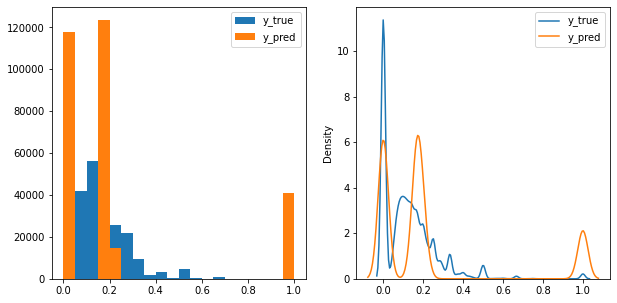

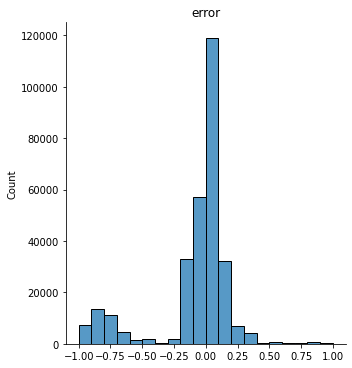

In [87]:
vis_utils.plot_regression_metrics(metrics)

In [96]:
metrics = ltr_metrics.metrics('validation')

Filtering non 0s from validation dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 58321 68.80722038697499
Number of 1s: 26439 31.192779613025014
Computing metrics with different ths
Using 0.4 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_th_metrics_0.pickle
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f82436/validation_class_metrics_0.pickle
Converting df scores
Filtering non 1s from validation dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Number of 0s: 84286 99.4407739499764
Number of 1s: 474 0.559226050023596
Computing metrics with different ths
Using 0.01 as th to optimize f1
Creating prediction labels and computing classification metrics
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_beinf/4554f8243

In [97]:
metrics

{'mse': 0.10209566065644823,
 'mae': 0.17765210033847245,
 'r2': -4.544320981646684,
 'y_true': array([0.25      , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.13333333]),
 'y_pred': array([0.19511347, 0.1777844 , 1.        , ..., 0.        , 0.        ,
        0.        ]),
 'error': array([ 0.05488653,  0.3222156 , -1.        , ...,  0.        ,
         0.        ,  0.13333333])}

mse : 0.10209566065644823
mae : 0.17765210033847245
r2 : -4.544320981646684


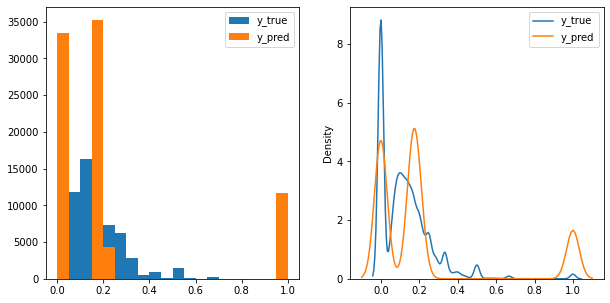

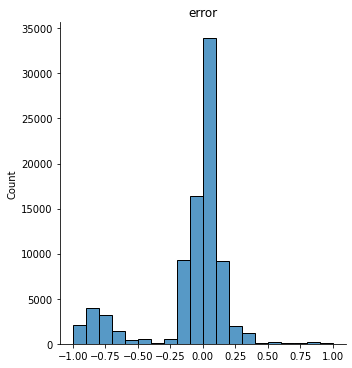

In [98]:
vis_utils.plot_regression_metrics(metrics)